In [2]:
!kaggle datasets download -d emmarex/plantdisease

Dataset URL: https://www.kaggle.com/datasets/emmarex/plantdisease
License(s): unknown
 99% 649M/658M [00:03<00:00, 201MB/s]
100% 658M/658M [00:03<00:00, 175MB/s]


In [3]:
import zipfile

zip_ref =zipfile.ZipFile('plantdisease.zip','r')
zip_ref.extractall('./')
zip_ref.close()

In [4]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt

In [5]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
EPOCHS = 50

In [6]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 20638 files belonging to 15 classes.


In [7]:
class_names = dataset.class_names
class_names

['Pepper__bell___Bacterial_spot',
 'Pepper__bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

In [8]:
len(dataset)

645

In [9]:
for image_batch,label_batch in dataset.take(1):
  print(image_batch.shape)
  print(label_batch.numpy())

(32, 256, 256, 3)
[ 5 12 12  7 11  7  3  7  0  7  9 13  7 11  7  5  7 11  5  5  0  9  7 12
  3  5 12 12  9  1 14 12]


In [10]:
label_batch.numpy()

array([ 5, 12, 12,  7, 11,  7,  3,  7,  0,  7,  9, 13,  7, 11,  7,  5,  7,
       11,  5,  5,  0,  9,  7, 12,  3,  5, 12, 12,  9,  1, 14, 12],
      dtype=int32)

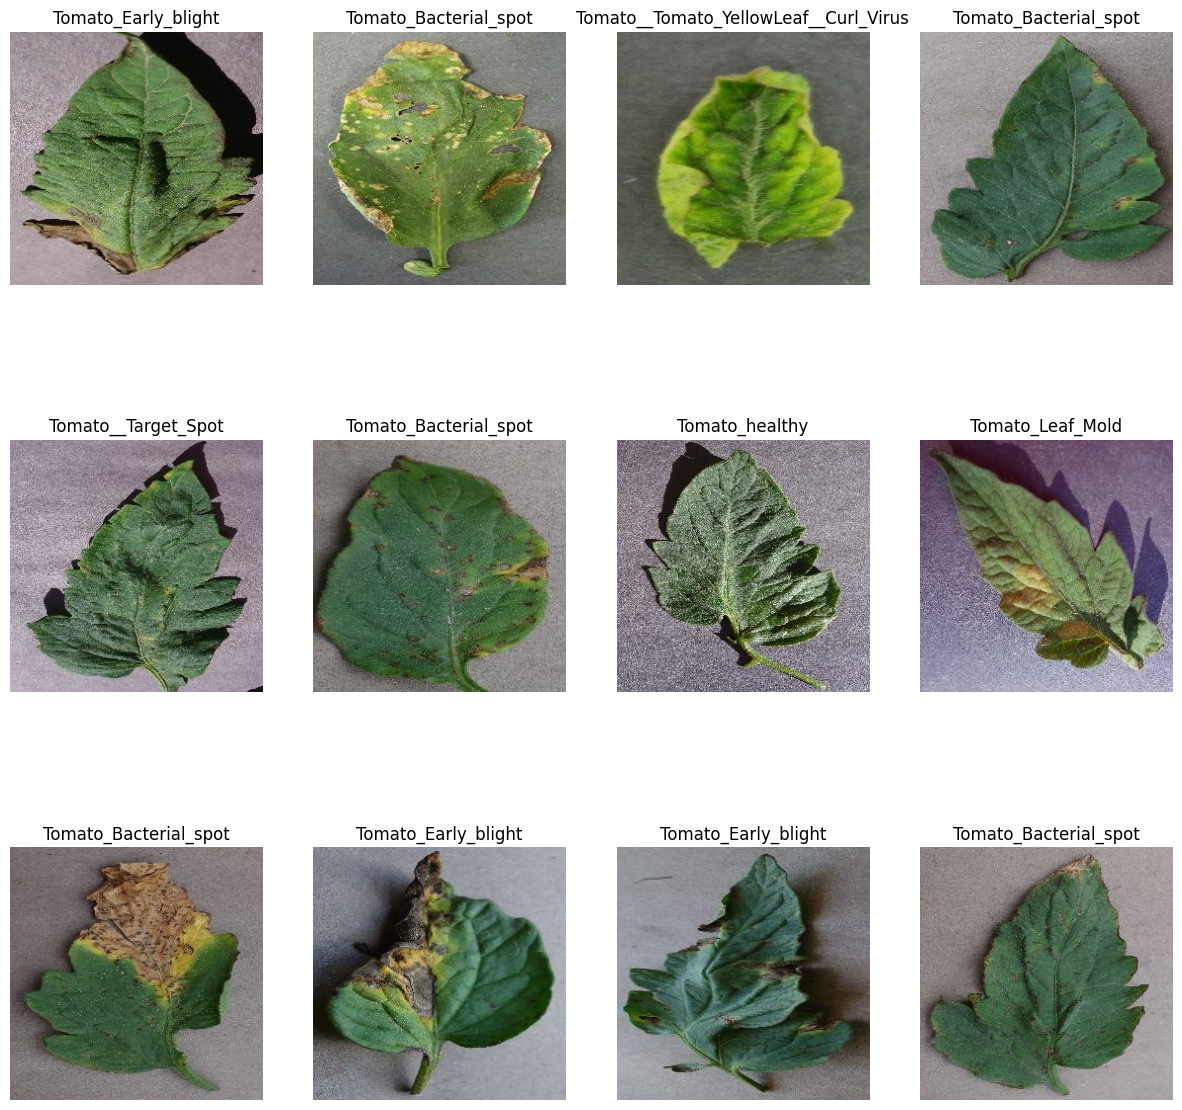

In [11]:
plt.figure(figsize = (15,15))
for image_batch,label_batch in dataset.take(1):
  for i in range(12):
    ax = plt.subplot(3,4,i+1)
    plt.imshow(image_batch[i].numpy().astype('uint8'))
    plt.axis('off')
    plt.title(class_names[label_batch[i]])
  # print(image_batch[0].numpy())

In [12]:
len(dataset)

645

In [13]:
def get_dataset_partitions_tf(ds,train_split = 0.8,val_split = 0.1,test_split = 0.1,shuffle = True,shuffle_size = 10000):
  assert (train_split + test_split + val_split) == 1
  ds_size = len(ds)
  if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

  train_size = int(train_split * ds_size)
  val_size = int(val_split * ds_size)

  train_ds = ds.take(train_size)
  val_ds = ds.skip(train_size).take(val_size)
  test_ds = ds.skip(train_size).skip(val_size)

  return train_ds, val_ds, test_ds

In [14]:
train_ds,val_ds,test_ds = get_dataset_partitions_tf(dataset)

In [15]:
len(train_ds)

516

In [16]:
len(val_ds)

64

In [17]:

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [18]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0 / 255),
])

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomWidth(0.2),
    layers.RandomHeight(0.2),
])

train_ds = train_ds.map(
    lambda x,y: (data_augmentation(x,training = True),y)
).prefetch(buffer_size = tf.data.AUTOTUNE)

In [19]:
CHANNELS = 3
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, (5, 5), activation='relu',padding = 'valid'),
    layers.Normalization(),
    # layers.Dropout(0.3),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu',padding = 'valid'),
    layers.Normalization(),
    # layers.Dropout(0.2),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu',padding = 'valid'),
    layers.Normalization(),
    # layers.Dropout(0.2),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Normalization(),
    layers.Dense(64, activation='relu'),
    layers.Normalization(),
    # layers.Dense(32, activation='relu'),
    # layers.Normalization(),
    # layers.Dense(16, activation='relu'),
    # layers.Normalization(),
    layers.Dense(len(class_names), activation='softmax'),
])

model.build(input_shape=input_shape)

In [20]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 252, 252, 32)        2432      
                                                                 
 normalization (Normalizati  (32, 252, 252, 32)        65        
 on)                                                             
                                                                 
 max_pooling2d (MaxPooling2  (32, 126, 126, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 124, 124, 64)        18496     
                                                                 
 normalization_1 (Normaliza  (32, 124, 124, 64)       

In [21]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint(
    filepath='best_model.h5',  # Path where the model will be saved
    monitor='val_accuracy',    # Metric to monitor (you can change this to 'accuracy' for training data)
    verbose=1,                 # Print messages during the saving process
    save_best_only=True,       # Save only the best model (highest accuracy)
    mode='max'                 # Maximize the monitored metric ('val_accuracy')
)


In [23]:
zip_ref = zipfile.ZipFile('/content/Model 17.zip','r')
zip_ref.extractall('/content/Model')
zip_ref.close()

In [24]:
model = tf.keras.models.load_model('/content/Model')

In [ ]:
model.compile(optimizer = 'adam',loss = 'sparse_categorical_crossentropy',metrics = ['accuracy'])
history = model.fit(train_ds,epochs = 1,validation_data = val_ds,callbacks = [checkpoint])

In [ ]:
# model.compile(optimizer = 'adam',loss = 'sparse_categorical_crossentropy',metrics = ['accuracy'])
# history = model.fit(train_ds,epochs = 2,validation_data = val_ds)

In [ ]:
h5_model = tf.keras.models.load_model('best_model.h5')

In [ ]:
h5_model.save('Model 17')

In [ ]:
model.save('/content/Model 17')
import shutil
from google.colab import files

shutil.make_archive('Model 17', 'zip', 'Model 17')
# files.download('Model 15.zip')

In [ ]:
# files.download('Model 5.0.zip')

In [ ]:
import numpy as np

In [ ]:
for image_batch,label_batch in test_ds.take(1):
  first_image = image_batch[0].numpy().astype('uint8')
  first_label = label_batch[0].numpy()

  print("First image to predict")
  plt.imshow(first_image)
  print(f"Actual Label: {class_names[first_label]}")
  batch_prediction = model.predict(image_batch)
  print(f"Predicted Label: {class_names[np.argmax(batch_prediction[0])]}")

In [27]:
def predict(model,img):
  img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
  img_array = tf.expand_dims(img_array,0) # create a batch we want to add this step because in training and validating we have loaded our dataset into batches like our train dataset is of size 516

  predictions = model.predict(img_array)

  predicted_class = class_names[np.argmax(predictions[0])]

  confidence = round(100* (np.max(predictions[0])),2)
  return predicted_class,confidence



1/1 [==============================] - 0s 40ms/step


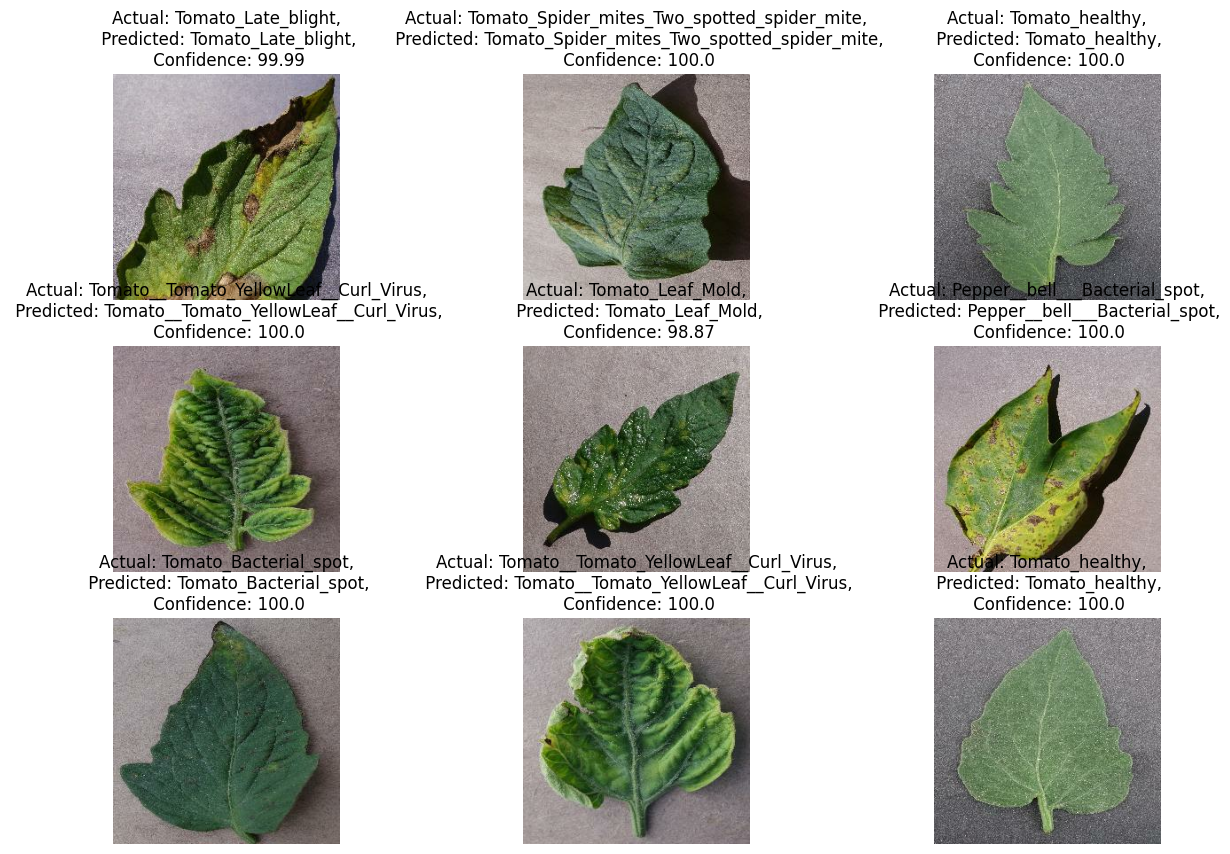

In [29]:
import numpy as np

plt.figure(figsize = (15,10))

for images,labels in test_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3,3,i+1)
    plt.axis('off')
    plt.imshow(images[i].numpy().astype('uint8'))

    predicted_class,confidence = predict(model,images[i].numpy())
    actual_class = class_names[labels[i]]

    plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class},\n Confidence: {confidence}")

In [ ]:
actual_labels = []
for images,labels in test_ds:
  actual_labels.append(labels.numpy())

In [25]:
loss, accuracy = model.evaluate(test_ds)

print('Test accuracy:', accuracy)

65/65 [==============================] - 10s 124ms/step - loss: 0.0614 - accuracy: 0.9870
Test accuracy: 0.9870067238807678
